# A simple ODE example

Comparison of DeepXDE and Jinns performance on 

$$
y_1^\prime(t) = y_2(t), \quad y_2^\prime(t)=-y_1(t)
$$
with $t \in [0, 10]$, initial condition $y_1(0)=0$ and $y_2(0)=1$, and reference solution $y_1 =\sin$, $y_2=\cos$
## DeepXDE
Example taken from : https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/ode.system.html

We use the JAX backend.

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Compiling model...


2024-10-22 15:10:18.724977: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


'compile' took 2.075974 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.02e-01, 4.93e-02, 0.00e+00, 1.00e+00]    [3.03e-01, 4.94e-02, 0.00e+00, 1.00e+00]    []  
1000      [8.05e-03, 8.87e-03, 1.82e-08, 3.62e-04]    [8.10e-03, 8.55e-03, 1.82e-08, 3.62e-04]    []  
2000      [6.37e-03, 5.27e-03, 7.48e-07, 1.69e-04]    [6.36e-03, 5.15e-03, 7.48e-07, 1.69e-04]    []  
3000      [4.18e-03, 4.07e-03, 1.61e-06, 8.99e-05]    [4.14e-03, 4.01e-03, 1.61e-06, 8.99e-05]    []  
4000      [1.65e-03, 2.47e-03, 3.53e-06, 3.28e-05]    [1.65e-03, 2.30e-03, 3.53e-06, 3.28e-05]    []  
5000      [4.79e-04, 7.72e-04, 1.46e-06, 5.65e-06]    [4.82e-04, 6.41e-04, 1.46e-06, 5.65e-06]    []  
6000      [1.03e-04, 1.92e-04, 2.53e-07, 8.81e-07]    [9.81e-05, 1.37e-04, 2.53e-07, 8.81e-07]    []  
7000      [5.99e-05, 8.10e-05, 2.06e-06, 3.53e-06]    [5.75e-05, 5.69e-05, 2.06e-06, 3.53e-06]    []  
8000      [2.64e-05,

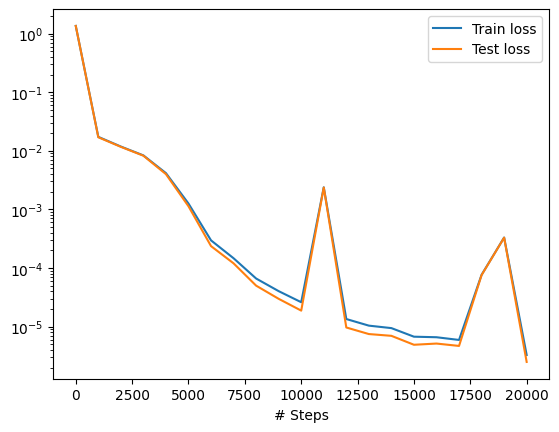

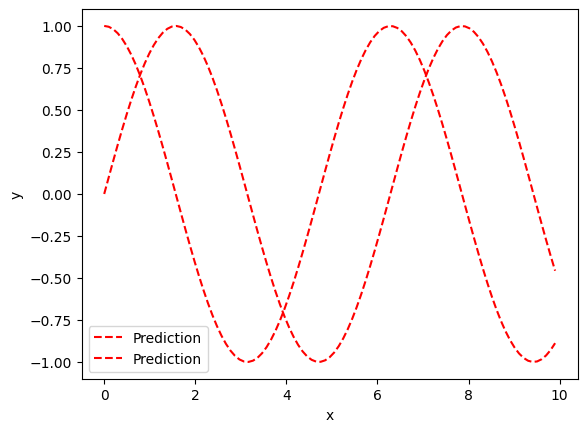

In [1]:
import os
os.environ["DDE_BACKEND"]="jax"
import deepxde as dde
import numpy as np

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(1234)


def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    # Most backends
    # y1, y2 = y[:, 0:1], y[:, 1:]
    # dy1_x = dde.grad.jacobian(y, x, i=0)
    # dy2_x = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    y_val, y_fn = y
    y1, y2 = y_val[:, 0:1], y_val[:, 1:]
    dy1_x, _ = dde.grad.jacobian(y, x, i=0)
    dy2_x, _ = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(
    geom,
    ode_system,
    [ic1, ic2],
    2000,#35,
    2,
    # solution=func,
    num_test=100,
    train_distribution="uniform", # equispaced grid
)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)#, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [2]:
data.train_next_batch()

[array([[0.      ],
        [0.      ],
        [0.      ],
        ...,
        [9.985007],
        [9.990005],
        [9.995003]], dtype=float32),
 None,
 None]

## With jinns

In [3]:
import jinns
import jax.numpy as jnp
from jax import random, vmap, grad
import jax
import equinox as eqx
import time

import matplotlib.pyplot as plt


In [4]:
key = random.PRNGKey(1234)

In [5]:
key, subkey = random.split(key)
nt = data.num_domain
batch_size = nt
method = "grid"
tmax = 1 # rescale time
Tmax = 10
train_data = jinns.data.DataGeneratorODE(
    key=subkey, tmin=0, tmax=1, nt=nt, temporal_batch_size=batch_size, method=method
)

In [6]:
eqx_list = (
    (eqx.nn.Linear, 1, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    [eqx.nn.Linear, 50, 50],
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 2),
)
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")

In [7]:
init_nn_params = u.init_params()
init_params = jinns.parameters.Params(nn_params=init_nn_params, eq_params={})

In [8]:
class OdeSystem(jinns.loss.ODE):
    def equation(self, t, u, params):
        u1 = lambda t: u(t, params)[0]
        u2 = lambda t: u(t, params)[1]

        y1, dt1 = jax.value_and_grad(u1)(t)
        y2, dt2 = jax.value_and_grad(u2)(t)

        return jnp.stack([dt1 - self.Tmax * y2, dt2 + self.Tmax * y1], axis=-1)

In [9]:
dynamic_loss = OdeSystem(Tmax=Tmax)

In [10]:
import jinns.loss


loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=jnp.array([1., 1.]),
    initial_condition=1.,
)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition= (jnp.array(0.0), jnp.array([0., 1.])),
    params=init_params
)

In [11]:
# # Testing the loss function
# losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)

# train_data, batch = train_data.get_batch()
# losses, grads = losses_and_grad(
#     init_params,
#     batch
# )
# l_tot, d = losses
# print(f"total loss: {l_tot}")
# print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

In [12]:
import optax
tx = optax.adam(learning_rate=0.001) # same as DeepXDE
n_iter = int(20000)
key, subkey = random.split(key)
begin = time.time()
params, total_loss, loss_by_term_dict, train_data, loss, opt_state, _ , _, _ = jinns.solve(
    n_iter=n_iter,
    init_params=init_params,
    data=train_data,
    loss=loss,
    optimizer=tx,
)
end = time.time()

Compilation took 1.3224663734436035
[train] Iteration 0: loss value = 1.5302480459213257
[train] Iteration 1000: loss value = 0.5914758443832397
[train] Iteration 2000: loss value = 0.39878326654434204
[train] Iteration 3000: loss value = 0.08849415928125381
[train] Iteration 4000: loss value = 0.018102554604411125
[train] Iteration 5000: loss value = 0.007360451389104128
[train] Iteration 6000: loss value = 0.07499855756759644
[train] Iteration 7000: loss value = 0.0028446149080991745
[train] Iteration 8000: loss value = 0.0021823542192578316
[train] Iteration 9000: loss value = 0.013618521392345428
[train] Iteration 10000: loss value = 0.0015001170104369521
[train] Iteration 11000: loss value = 0.0013498715125024319
[train] Iteration 12000: loss value = 0.0011392992455512285
[train] Iteration 13000: loss value = 0.002508669625967741
[train] Iteration 14000: loss value = 0.0009497335413470864
[train] Iteration 15000: loss value = 0.0008443830884061754
[train] Iteration 16000: loss val

In [13]:
print(f"Training took {end - begin}s user time.")

Training took 21.963983058929443s user time.


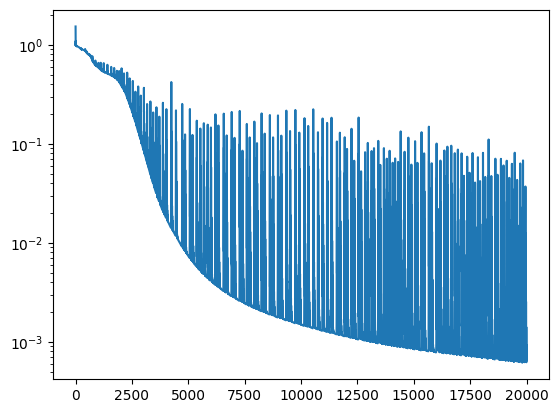

In [14]:
plt.plot(total_loss)
plt.yscale("log")

In [15]:
key, subkey = random.split(key)
t_val = jnp.linspace(0, Tmax, 200)
t_val_rescaled = t_val / Tmax
u_est = vmap(lambda t: u(t, params))(t_val_rescaled)
y1, y2 = u_est[:, 0], u_est[:, 1]

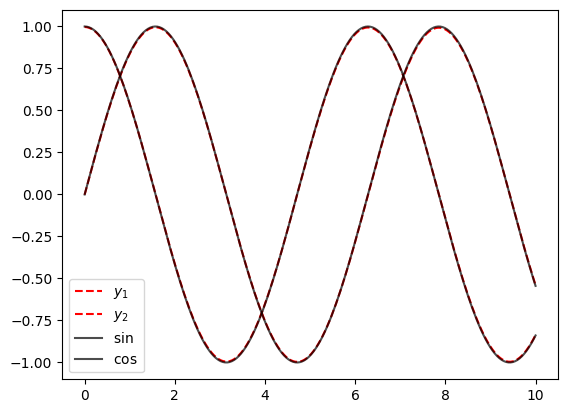

In [16]:

plt.plot(t_val, y1, label=r"$y_1$", color="red", linestyle="--")
plt.plot(t_val, y2, label=r"$y_2$", color="red", linestyle="--")
plt.plot(t_val, jnp.sin(t_val), label=r"$\sin$", color="black", linestyle="-", alpha=.7)
plt.plot(t_val, jnp.cos(t_val), label=r"$\cos$", color="black", linestyle="-", alpha=.7)

plt.legend()